In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import mae
from tensorflow.keras import layers
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, classification_report
import os

# PTBD

# EDA

In [3]:
normal = pd.read_csv('ptbdb_normal.csv')
abnormal = pd.read_csv('ptbdb_abnormal.csv')

In [4]:
print("Data set shape is ",abnormal.shape)
normal.head()

Data set shape is  (10505, 188)


,1.000000000000000000e+00,9.003241658210754395e-01,3.585899472236633301e-01,5.145867168903350830e-02,4.659643396735191345e-02,1.268233358860015869e-01,1.333063244819641113e-01,1.191247999668121338e-01,1.106158867478370667e-01,1.130470037460327148e-01,...,0.000000000000000000e+00.56,0.000000000000000000e+00.57,0.000000000000000000e+00.58,0.000000000000000000e+00.59,0.000000000000000000e+00.60,0.000000000000000000e+00.61,0.000000000000000000e+00.62,0.000000000000000000e+00.63,0.000000000000000000e+00.64,0.000000000000000000e+00.65
0,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.948983,0.505265,0.004176,0.022513,0.059550,0.107298,0.110385,0.111293,0.116558,0.118192,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


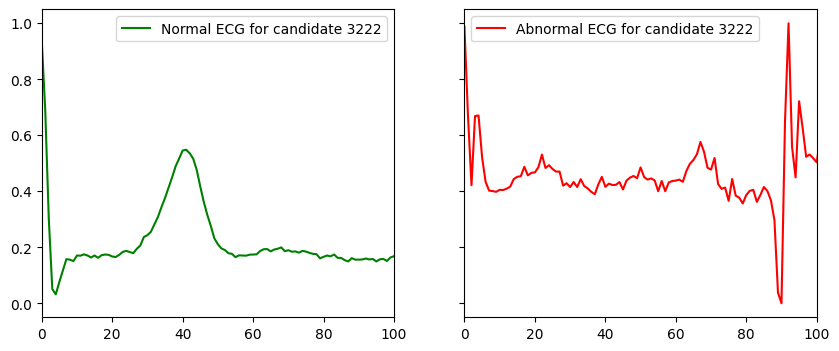

In [5]:
fig, ax = plt.subplots(1,2, figsize = (10,4), sharey = True)

index = np.random.randint(0,len(normal),2)
ax[0].plot(normal.iloc[index[0],:].values, label = f'Normal ECG for candidate {index[0]}', color = 'green')
ax[0].legend()
ax[0].set_xlim([0,100])
ax[1].plot(abnormal.iloc[index[0],:].values, label = f'Abnormal ECG for candidate {index[0]}', color = 'red')
ax[1].legend()
ax[1].set_xlim([0,100])
plt.show()



From the graph it is becoming clear that abnormal ECGs tend to have more jitters in the graph.

In [6]:
CLASS_NAMES = ["Normal", "Anomaly"]

normal_df_copy = normal.copy()
abnormal_df_copy = abnormal.copy()


In [7]:
normal_df_copy = normal_df_copy.set_axis(range(1,189), axis =1)
abnormal_df_copy = abnormal_df_copy.set_axis(range(1,189), axis =1)
normal_df_copy = normal_df_copy.assign(target = CLASS_NAMES[0])
abnormal_df_copy = abnormal_df_copy.assign(target = CLASS_NAMES[1])

df = pd.concat((normal_df_copy, abnormal_df_copy))

In [8]:
df['target']

0         Normal
1         Normal
2         Normal
3         Normal
4         Normal
          ...   
10500    Anomaly
10501    Anomaly
10502    Anomaly
10503    Anomaly
10504    Anomaly
Name: target, Length: 14550, dtype: object

In [9]:
df.to_csv('joined_ptbd_with_target')

In [10]:
X = df.drop(columns = 'target')
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42)

# Creating an Autoencoder

In [11]:
class AutoEncoder(Model):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential([
            layers.Input(shape = (input_dim,)),
            layers.Reshape((input_dim, 1)),
            layers.Conv1D(64,3,strides =1, activation = 'relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(latent_dim, 3, strides =1, activation ='relu', padding ="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),  
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv1D(latent_dim, 3, strides =1, activation ='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64,3,strides =1, activation = 'relu', padding = "same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Flatten(),
            layers.Dense(input_dim)
        ])


    def call(self,X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    

input_dim = X_train.shape[1]
latent_dim = 32

model = AutoEncoder(input_dim, latent_dim)
model.build((None, input_dim))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mae')
model.summary()

Model: "auto_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 47, 32)            6816      
                                                                 
 sequential_1 (Sequential)   (None, 188)               2271900   
                                                                 
Total params: 2278716 (8.69 MB)
Trainable params: 2278332 (8.69 MB)
Non-trainable params: 384 (1.50 KB)
_________________________________________________________________


In [12]:
early_stopping = EarlyStopping(patience=10, min_delta=1e-3, monitor="val_loss", restore_best_weights=True)


history = model.fit(X_train, X_train, epochs=55, batch_size=64,
                    validation_split=0.1, callbacks=[early_stopping])

Epoch 1/55
164/164 [==============================] - 19s 95ms/step - loss: 2.1312 - val_loss: 0.3233
Epoch 2/55
164/164 [==============================] - 16s 97ms/step - loss: 0.4390 - val_loss: 0.1906
Epoch 3/55
164/164 [==============================] - 21s 130ms/step - loss: 0.1609 - val_loss: 0.0811
Epoch 4/55
164/164 [==============================] - 16s 100ms/step - loss: 0.0710 - val_loss: 0.0500
Epoch 5/55
164/164 [==============================] - 19s 116ms/step - loss: 0.0471 - val_loss: 0.0434
Epoch 6/55
164/164 [==============================] - 22s 133ms/step - loss: 0.0337 - val_loss: 0.0287
Epoch 7/55
164/164 [==============================] - 22s 134ms/step - loss: 0.0297 - val_loss: 0.0366
Epoch 8/55
164/164 [==============================] - 17s 106ms/step - loss: 0.0290 - val_loss: 0.0256
Epoch 9/55
164/164 [==============================] - 19s 115ms/step - loss: 0.0259 - val_loss: 0.0220
Epoch 10/55
164/164 [==============================] - 19s 113ms/step - los

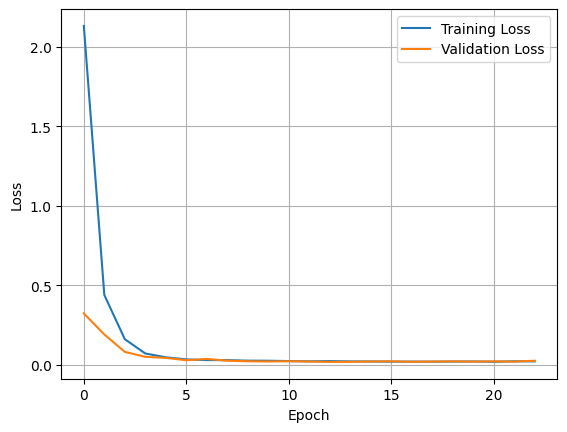

In [17]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()

# Evaluation